In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier



In [ ]:
# Load the datasets
train_df = pd.read_csv("KDDTrain+.txt", header=None)
test_df = pd.read_csv("KDDTest+.txt", header=None)


In [ ]:

# Load training data
train_df = pd.read_csv("KDDTrain+.txt", header=None)
print("Training data shape:", train_df.shape)

# Define column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'score'
]
train_df.columns = columns

# Encode categorical features
categorical_columns = ['protocol_type', 'service', 'flag']
encoders = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    train_df[col] = encoder.fit_transform(train_df[col])
    encoders[col] = encoder

# Convert labels to binary (1 = anomaly, 0 = normal)
y_train = train_df['label'].apply(lambda x: 1 if x != 'normal' else 0)

# Drop non-feature columns
X_train = train_df.drop(columns=['label', 'score'])

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, timesteps=1, features)


Training data shape: (125973, 43)


In [ ]:
from sklearn.tree import DecisionTreeClassifier


dt_model = DecisionTreeClassifier(
    criterion='entropy',          # Changed criterion to 'entropy'
    max_depth=15,                 # Increased max depth to allow more splits
    min_samples_split=4,          # Require at least 4 samples to split an internal node
    min_samples_leaf=2,           # Require at least 2 samples at each leaf node
    max_features='sqrt',          # Use square root of the total features for each split
    random_state=42,
    splitter='best',              #to  Choose the best split at each node
    class_weight='balanced',      # to automatically adjusts weights for imbalanced classes
    max_leaf_nodes=20             # to limit the number of leaf nodes to 20
)

# Reshape data back to 2 dimensions
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[2])  # Reshape to (samples, features)

# Train the model using the 2D data
dt_model.fit(X_train_2d, y_train)

print("Model trained successfully.")


Model trained successfully.


In [ ]:
# Save the trained model
import joblib
joblib.dump(dt_model, 'decision_tree_model.pkl')
print("Model saved as 'decision_tree_model.pkl'")

Model saved as 'decision_tree_model.pkl'


In [ ]:
# Load testing data
test_df = pd.read_csv("KDDTest+.txt", header=None)
print("Testing data shape:", test_df.shape)

# Assign column names to match the training dataset
test_df.columns = columns

# Encode categorical features using the same encoders used for training
for col in categorical_columns:
    test_df[col] = encoders[col].transform(test_df[col])

# Convert labels to binary (1 = anomaly, 0 = normal)
y_test = test_df['label'].apply(lambda x: 1 if x != 'normal' else 0)

# Drop non-feature columns
X_test = test_df.drop(columns=['label', 'score'])

# Scale features using the same scaler used for training
X_test = scaler.transform(X_test)

# Reshape data for LSTM
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, timesteps=1, features)


Testing data shape: (22544, 43)


In [ ]:
# Load the saved model
loaded_model = joblib.load('decision_tree_model.pkl')

In [ ]:
# Make predictions
X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[2])  # Reshape to (samples, features)
y_pred = loaded_model.predict(X_test_2d)

In [ ]:

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy on test data: 0.8152945351312988
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.97      0.82      9711
           1       0.96      0.70      0.81     12833

    accuracy                           0.82     22544
   macro avg       0.84      0.83      0.82     22544
weighted avg       0.85      0.82      0.81     22544

Confusion Matrix:
 [[9377  334]
 [3830 9003]]


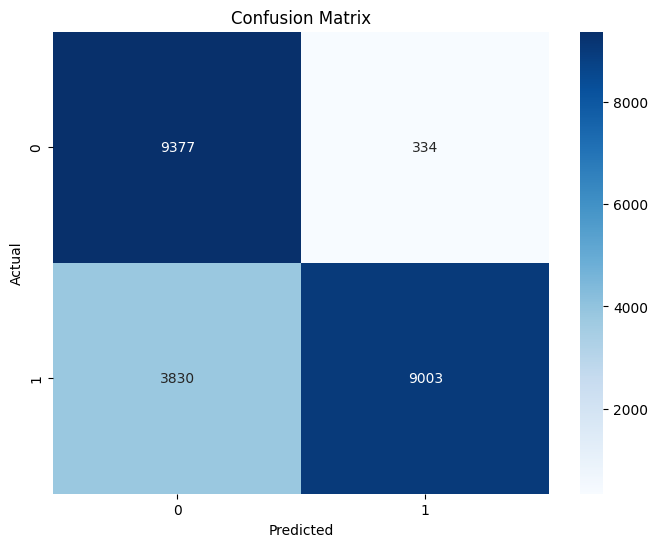

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


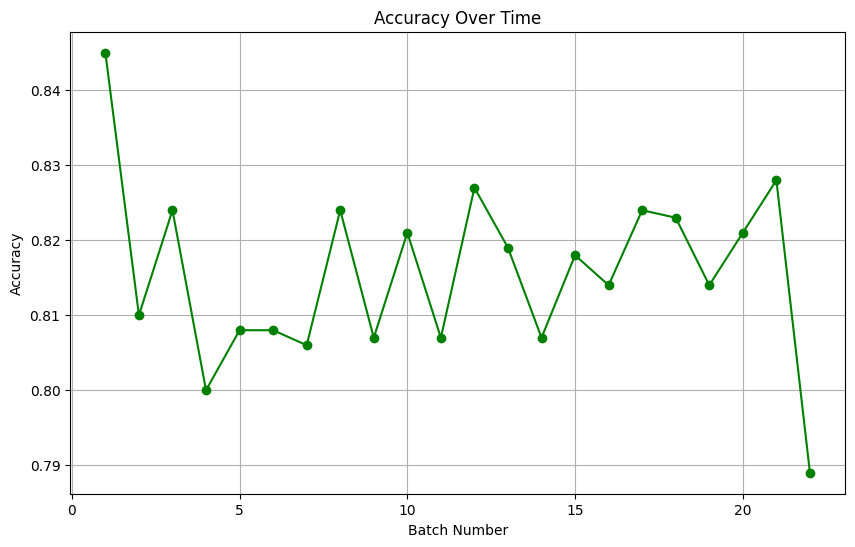

In [ ]:
# Simulate batch predictions (divide test set into batches)
batch_size = 1000
batches = len(y_test) // batch_size
accuracy_over_time = []

for i in range(batches):
    batch_y_test = y_test[i * batch_size:(i + 1) * batch_size]
    batch_y_pred = y_pred[i * batch_size:(i + 1) * batch_size]
    batch_accuracy = accuracy_score(batch_y_test, batch_y_pred)
    accuracy_over_time.append(batch_accuracy)

# Plot accuracy over batches
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_over_time) + 1), accuracy_over_time, marker='o', color='green')
plt.title('Accuracy Over Time')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
